In [1]:
%pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
def optimize_dataframe_for_memory(df):
 print("current memeor usage: ", df.memory_usage().sum() / 1024**2, "MB")

 for col in df.columns:
  _max = df[col].max()
  _min = df[col].min()
  if df[col].dtype  == 'int64':
   if _min > np.iinfo(np.int8).min and _max < np.iinfo(np.int8).max:
    df[col] = df[col].astype(np.int8)
   elif _min > np.iinfo(np.int16).min and _max < np.iinfo(np.int16).max:
    df[col] = df[col].astype(np.int16)
   elif _min > np.iinfo(np.int32).min and _max < np.iinfo(np.int32).max:
    df[col] = df[col].astype(np.int32)
  elif df[col].dtype == 'float64':
   if _min > np.finfo(np.float16).min and _max < np.finfo(np.float16).max:
    df[col] = df[col].astype(np.float16)
   elif _min > np.finfo(np.float32).min and _max < np.finfo(np.float32).max:
    df[col] = df[col].astype(np.float32)
  else:
   continue
 
 print("new memory usage: ", df.memory_usage().sum() / 1024**2, "MB")
 return df

In [4]:
data_set_location  = 'data/'

In [5]:
df = pd.read_pickle(data_set_location + 'final_data.pkl')

df = optimize_dataframe_for_memory(df)

current memeor usage:  4445.136594772339 MB
new memory usage:  1268.884446144104 MB


In [6]:
df.head(3)

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,reordered_average_order_size_x,reordered_reorder_in_order_x,reordered_average_order_size_y,reordered_reorder_in_order_y,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.899902,1.400391,17.59375,10.0,1.0,1.0,...,5.898438,0.706055,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504
1,1,10258,9.0,8.0,0.888672,3.333984,19.56250,10.0,1.0,1.0,...,5.898438,0.706055,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504
2,1,10326,1.0,0.0,0.000000,5.000000,28.00000,5.0,0.0,0.0,...,5.898438,0.706055,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504


In [7]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [8]:
X = df [ df.columns.drop('reordered') ]
Y = df ['reordered']

In [9]:
Y.isnull().sum()

0

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y , stratify = Y ,  test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 68) (6355995,)
(2118666, 68) (2118666,)


In [17]:
y_train.value_counts()

0.0    5734377
1.0     621618
Name: reordered, dtype: int64

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

In [19]:
params = {
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "eta"              :0.1,
    "max_depth"        :6,
    "min_child_weight" :10,
    "gamma"            :0.70,
    "subsample"        :0.76,
    "colsample_bytree" :0.95,
    "alpha"            :2e-05,
    "scale_pos_weight" :10,
    "lambda"           :10
}



In [20]:
evals= [(train, "train")]
model = xgb.train(params=params, dtrain=train, num_boost_round = 80, evals = evals , verbose_eval = 10)

[0]	train-logloss:0.69451
[10]	train-logloss:0.56408
[20]	train-logloss:0.53718
[30]	train-logloss:0.52933
[40]	train-logloss:0.52587
[50]	train-logloss:0.52425
[60]	train-logloss:0.52324
[70]	train-logloss:0.52244
[79]	train-logloss:0.52180


In [21]:
pred = model.predict(test)
pred = [1 if x > 0.5 else 0 for x in pred]

In [22]:
print ("\n Classification report : \n",classification_report(y_test, pred))
print ("Accuracy   Score : ",accuracy_score(y_test, pred))



 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.24      0.77      0.37    207206

    accuracy                           0.74   2118666
   macro avg       0.60      0.75      0.60   2118666
weighted avg       0.90      0.74      0.79   2118666

Accuracy   Score :  0.7413792452420532


Text(0.5, 606.7222222222223, 'Predicted Values')

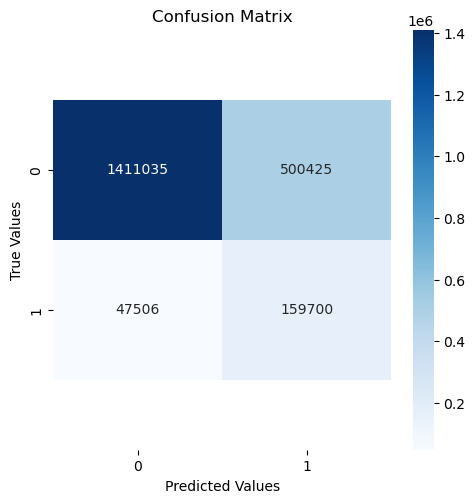

In [24]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

Area under curve:  0.7544640403894506 



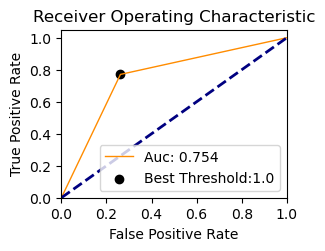

In [26]:
#roc_auc_score
model_roc_auc = roc_auc_score(y_test, pred) 
print("Area under curve: ", model_roc_auc, "\n")
fpr, tpr, thresholds = roc_curve(y_test, pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix], 3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label="Auc: %.3f" % model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

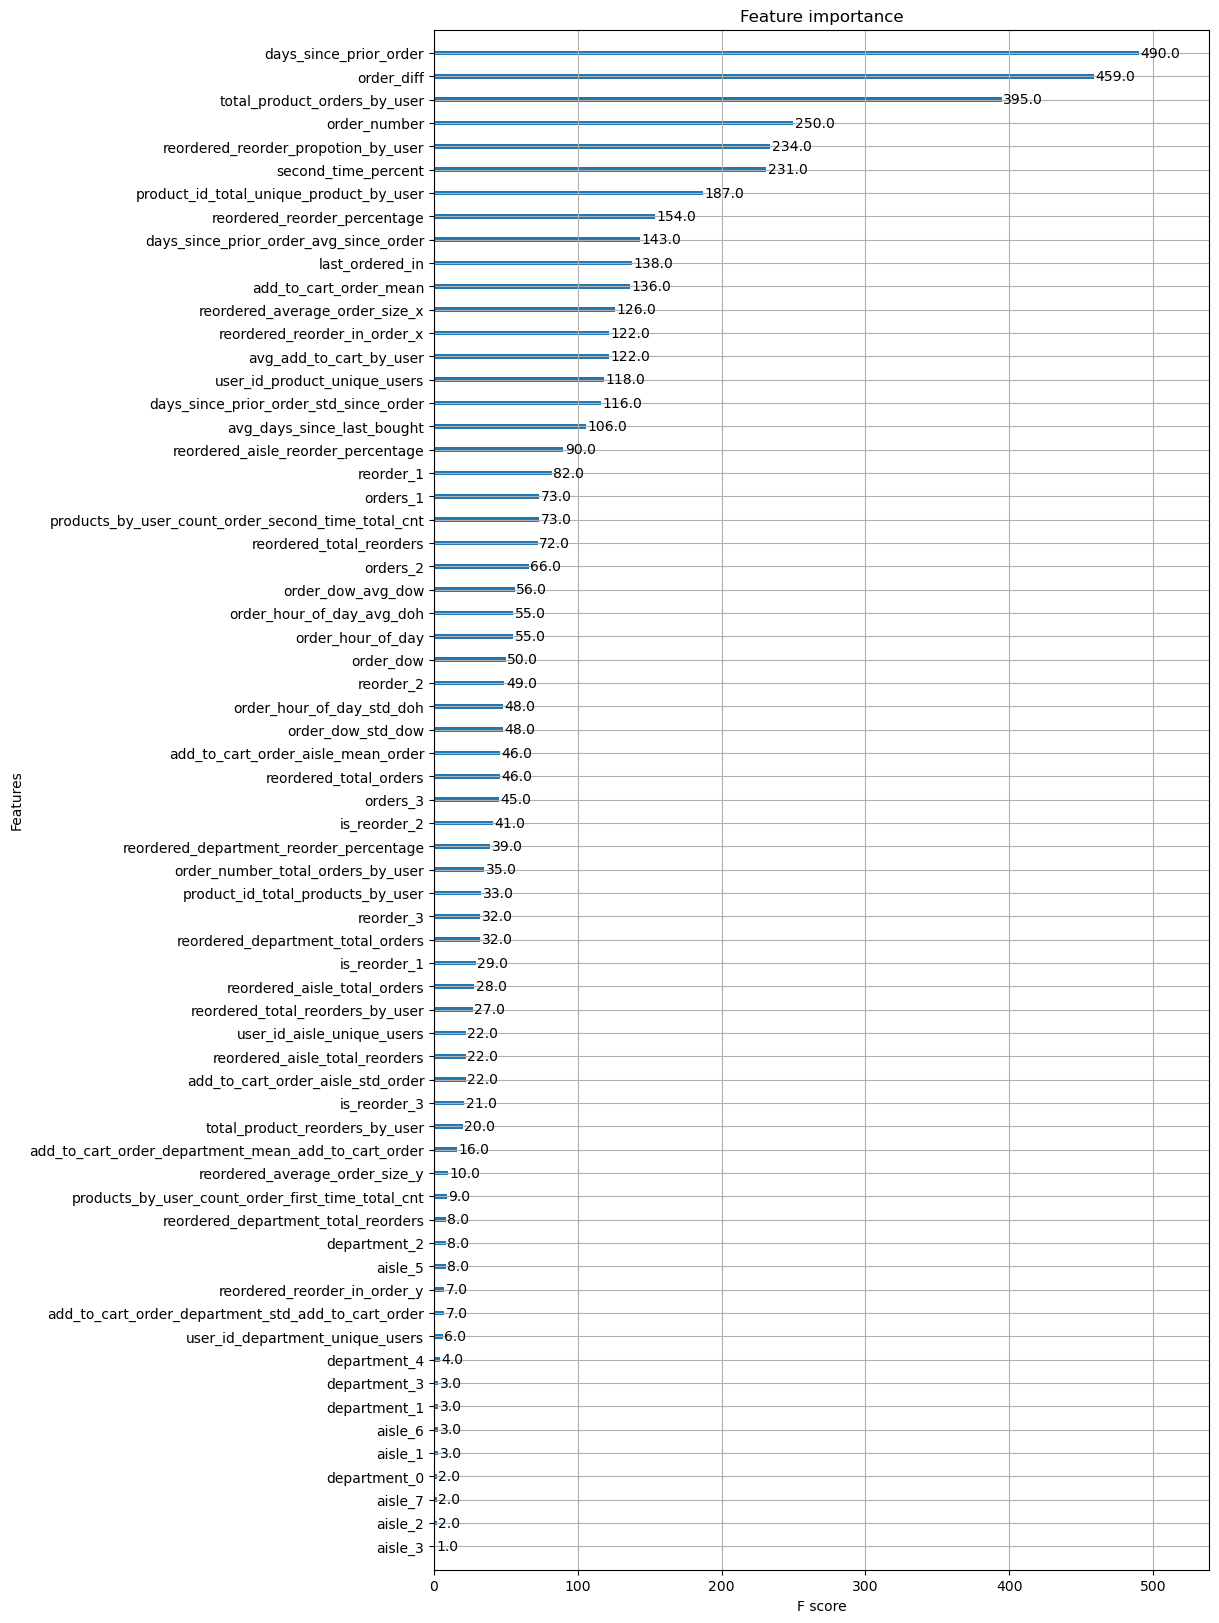

In [29]:
fig, ax = plt.subplots(figsize = (10,20))
xgb.plot_importance(model, ax = ax)